In [63]:
%load_ext autoreload
%autoreload 2    

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.tree import *
from spatial_scene_grammars.sampling import *

from spatial_scene_grammars_examples.planar_box_stacks.grammar import *

def inv_softplus(y, beta=1., eps=1E-9):
    # y = 1/beta * log(1 + exp(beta * x))
    # so
    # x = log(exp(beta * y) - 1)/beta
    # Y better be > 0, of course.
    if isinstance(y, float):
        y = torch.tensor(y)
    y = torch.clip(y, min=eps)
    return torch.log(torch.exp(beta * y) - 1.)/beta
def inv_sigmoid(y, eps=1E-9):
    # y = 1 / (1 + exp(-x))
    # so
    # x = -log((1 / y)-1)
    # Y better be in [0, 1]
    if isinstance(y, float):
        y = torch.tensor(y)
    y = torch.clip(y, min=eps, max=1.-eps)
    return -torch.log((1 / y) - 1)
x_test = torch.normal(0., 1., size=(100,))
assert torch.allclose(inv_softplus(torch.nn.functional.softplus(x_test)), x_test)
assert torch.allclose(inv_sigmoid(torch.nn.functional.sigmoid(x_test)), x_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Unconditional grammar outputs look like this:

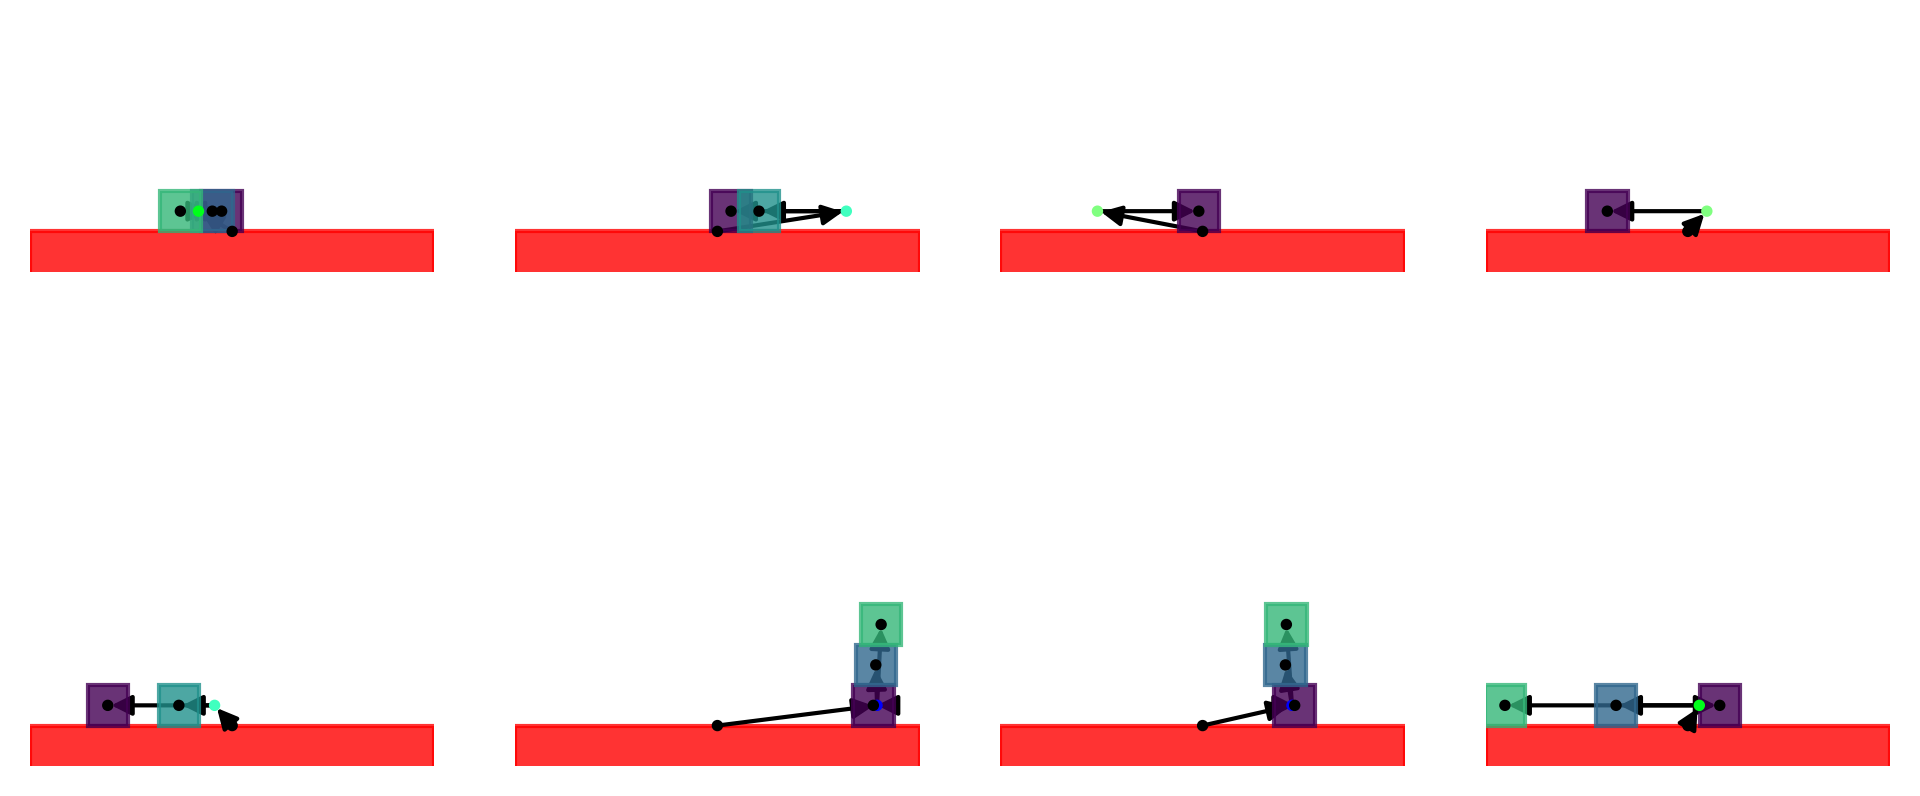

In [65]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(41)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = SceneTree.forward_sample_from_root_type(
                Ground, {"xy": torch.tensor([0., 0.])})
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

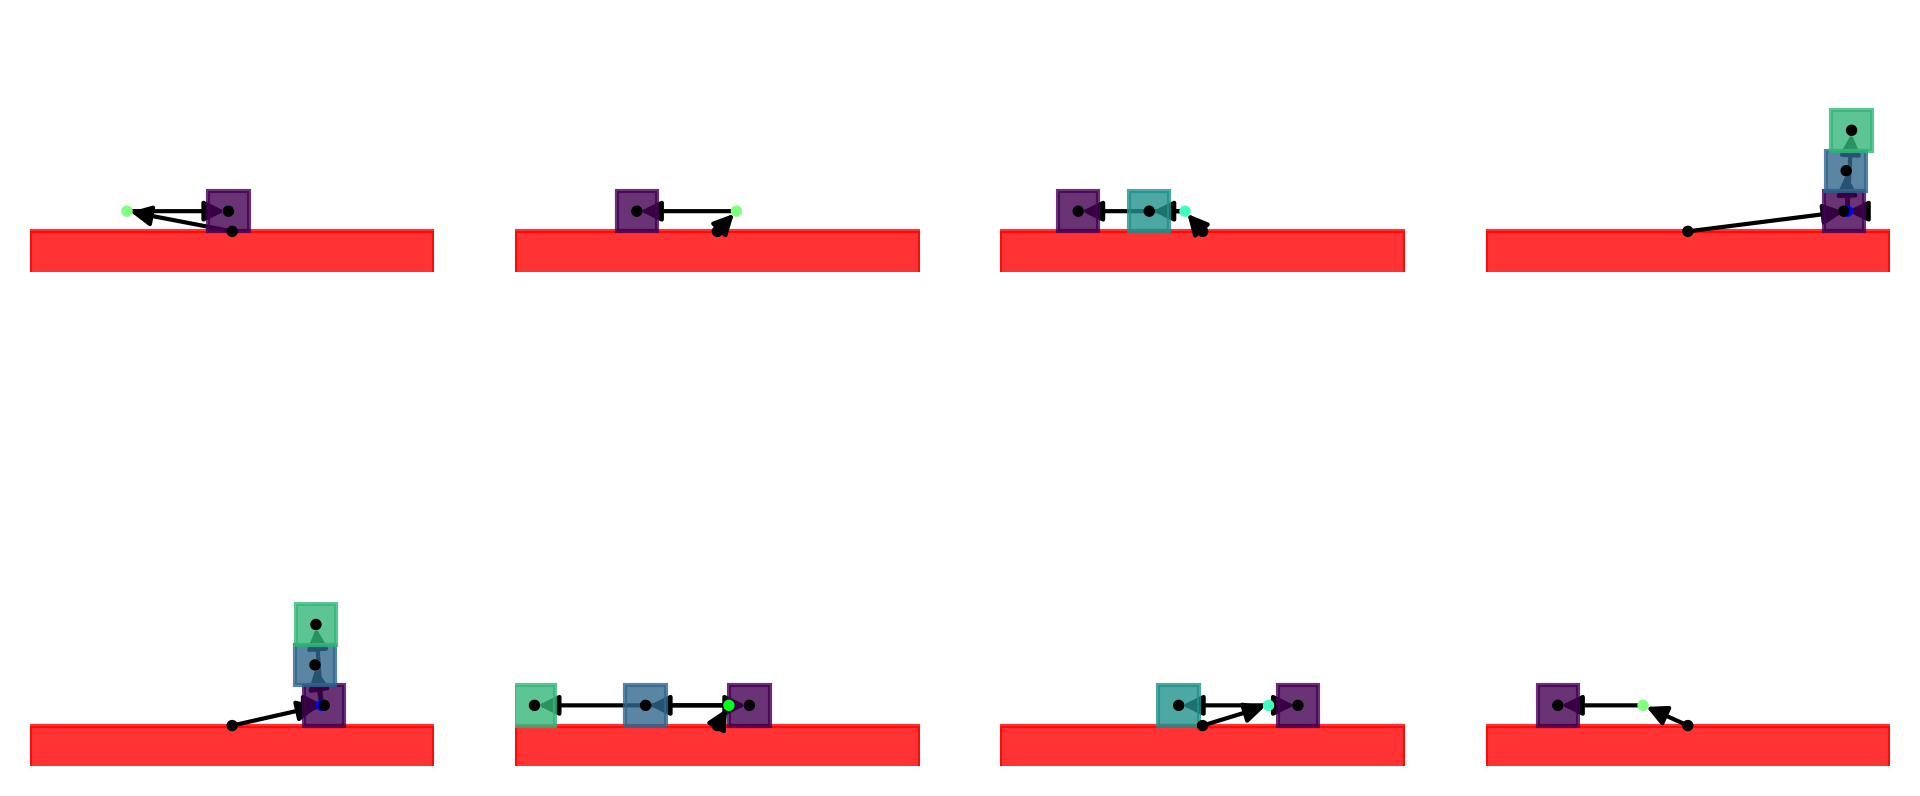

In [66]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(41)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict={
                "xy": torch.tensor([0., 0.])
            },
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [67]:
trace = pyro.poutine.trace(SceneTree.forward_sample_from_root_type).get_trace(
    Ground, {"xy": torch.tensor([0., 0.])})
print(trace.nodes.keys())

odict_keys(['_INPUT', 'Ground_279_choose_children/or_sample', 'Ground_279_instantiate_children/child_0_x', 'StackOf3_463_instantiate_children/child_0_xy', 'StackOf3_463_instantiate_children/child_1_xy', 'StackOf3_463_instantiate_children/child_2_xy', '_RETURN'])


The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(327.93485000000004, 713.23515, -16.899900000000002, 385.2799)

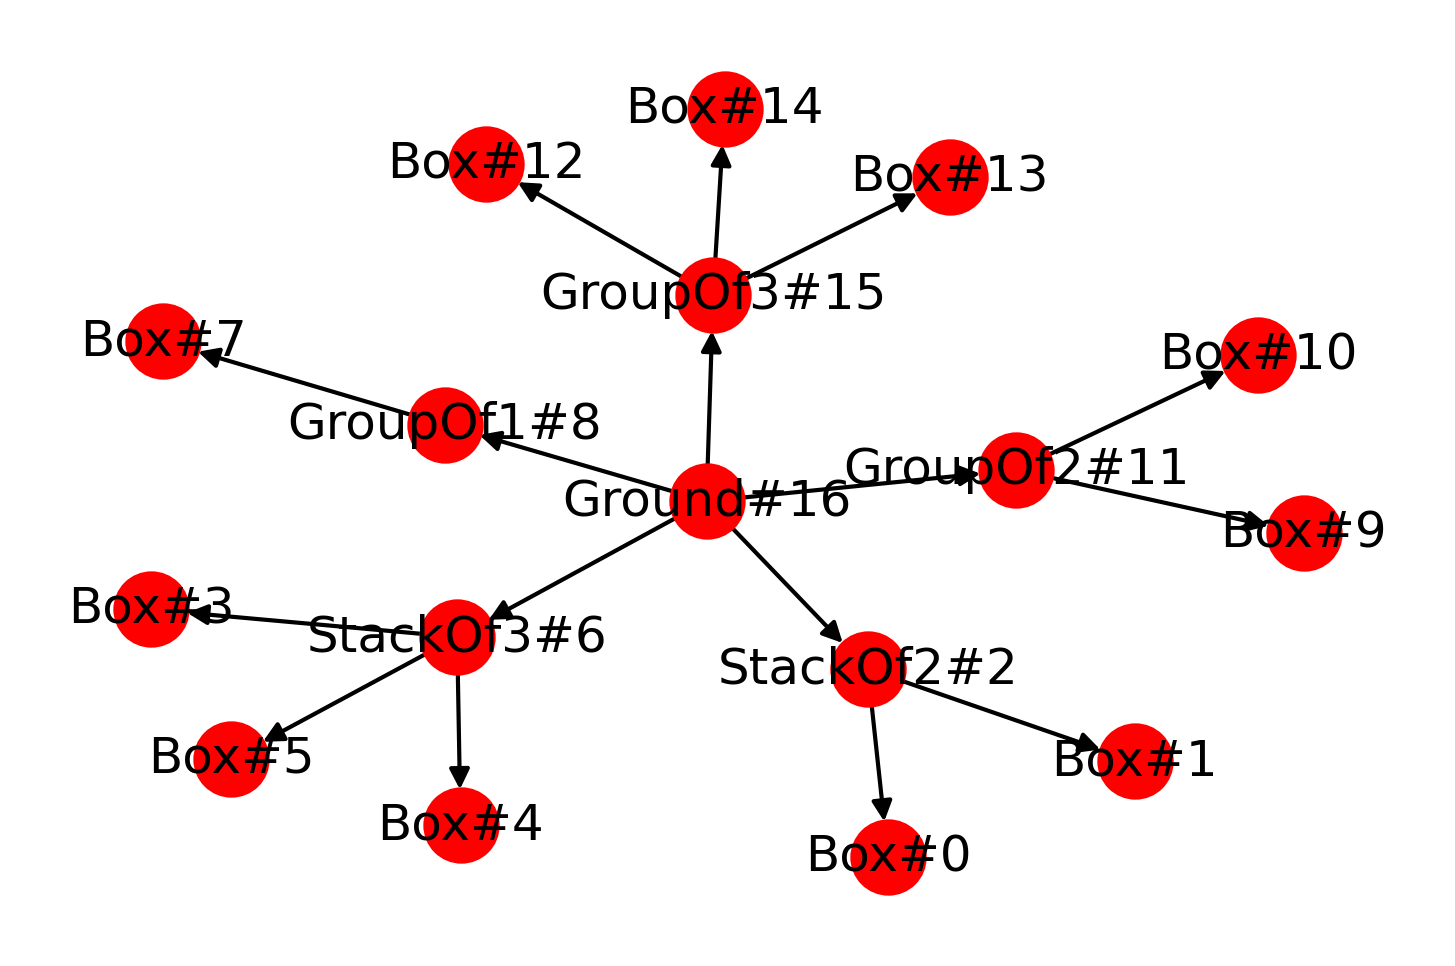

In [68]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneTree.make_meta_scene_tree(Ground())
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ + "#" + str(index_by_node[node]) for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

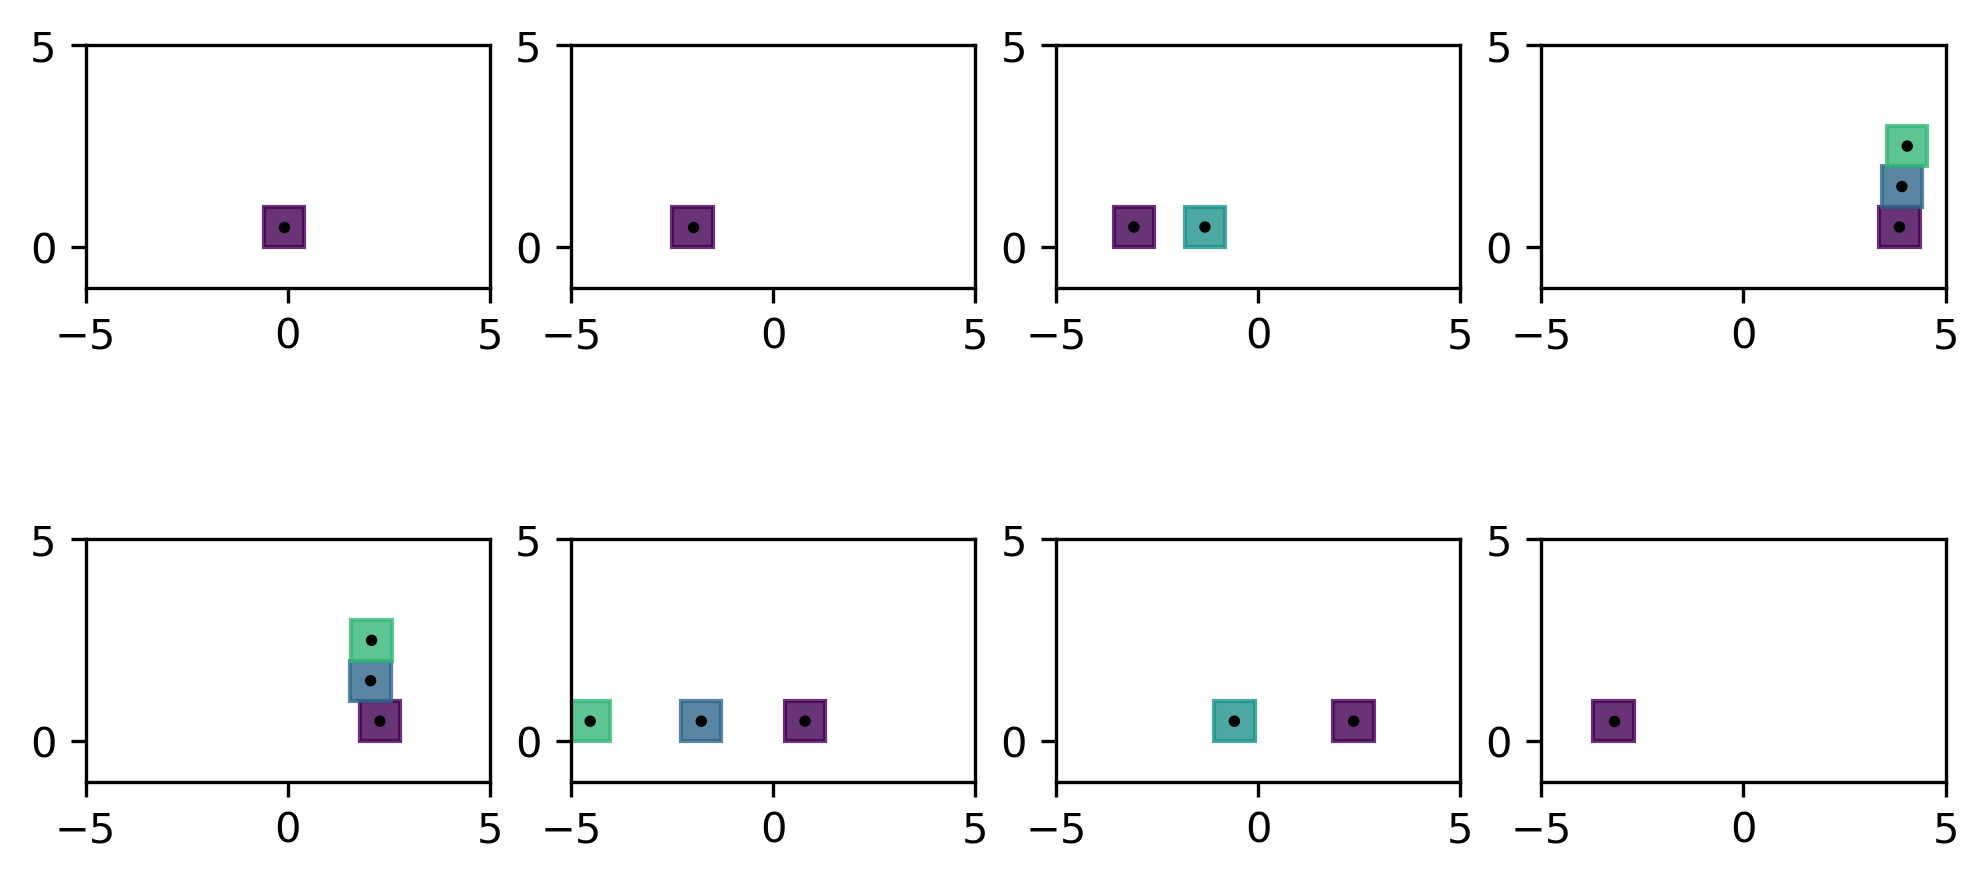

In [69]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(41)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## I'm an idiot and rederive MPM
Top-down sampling approach: starting by defining an "observation likelihood" function $p(o | t)$ (observations $o$, proposed tree $t$. Scenes with the wrong number of boxes get -inf scores; scenes with the right number get scored based on distance. This is the density of an observation process where all the boxes in the underlying tree produce boxes with small noise around their generated location (have to deal with generated-to-observed box correspondences, though -- either evaluate them all or take the best one and claim the others don't contribute?); maybe this observation process should get formalized + included in the generative scene spec if this approach is what I go with moving forward.

Sample trees from the prior $p(t)$, likelihood is an evaluation of $p(o | t)$. If we want to draw samples from $p(t | o) = \dfrac{p(o, t)}{p(o)} = \dfrac{p(o | t) p(t)}{p(o)}$, treat it as an importance sampled population; I think it'll come out to drawing random samples from the generated pool with prob $\dfrac{p(o, t_j)}{\sum_i p(o, t_i)}$ for sampled tree $i$.

Or we could interleave with local search: tree "jumps" fit into MCMC, where the MH acceptance $a = min(1, \dfrac{p(t' | o)}{p(t | o)}\dfrac{p(t)}{p(t')})$ (the forward and reverse transition probabilities come from just sampling the tree proposals from their priors), which I think cancels down to $a = min(1, \dfrac{p(o | t')}{p(o | t)})$. This feels like SMC? I think we can interleave that proposal with local fixed-structure MCMC steps using a drift or HMC proposal.

Wait, I'm an idiot, this is just MPM again. Doh

## Top-down parsing with neural conditionally-transformed grammars
OK, explicitly non-MPM take: what if we lots of random sampling from the prior (or another proposal density) over tree structures to build a (probabilistically complete) library of topologies, but we only accept/reject them based on whether they are *feasible* w.r.t. our observed set of objects. (The density of each is $p(t_{fixed})$ normalized by the sum of densities of trees in the library, I think.) Then, for each one, we run MCMC or VI to get the posterior of the continuous variables given the fixed tree structure. Then we can reconstruct the density for the whole distribution by combining $p(t_{fixed} | o)p(t_{continuous} | o))$.

An advantage here is that we could try to **train neural proposals for proposal densities over trees** (by having the neural part consume the observed objects and produce altered grammar parameters) -- this may make it possible to sample relatively exhaustive topology libraries with relatively low cost. (It'd be trained, I hope, to not only sample feasible topologies, but sample ones that will ultimately have high likelihood in the full posterior.) Rather than trusting hybrid MCMC to traverse the space of trees like MPM, we instead try to build an exhaustive set of the interesting structure up-front. (This is maybe a good fit for us -- we have shallower grammars than MPM did.) But we'll scale very poorly because of that; we might have to be very careful about grammar design to not scale poorly. And we're asking the neural proposal part to work serious miracles.

Step one on trying this is seeing if I can train a network to consume an observed node set and spit out grammar parameters that create trees with matching observed node sets. We have some degrees of freedom:
- What's the grammar? We could re-use the topology parts of the original grammar; all parameters of the original grammar; or create a new grammar that takes more context into account (e.g. roll out the super-scene-tree, and treat each node in the scene tree as having its own instance of the grammar parameters, so the network has separate control of how each "path" it's taking can evolve).
- What's the objective? Probably want something divergence-like between the induced tree set and the observed node set. Could score just whether the observed nodes are feasible in the generated topologies, or how well the observed node set is explained by the terminal nodes of the generated trees.

Also possible to do a bottom-up pass to form the grammar rules per node (label all the places the observed nodes could enter the super scene tree; advance upwards like a layered transformer kind of thing spitting out grammar rules for the traversed nodes of the super scene tree;). Then the resulting system can be rolled out to sample from the set of proposed trees, and the rollouts can have densities attached -- this is an encoder/decoder sort of idea.

#### Experiment using the grammar itself as the parameterization for the posterior distribution.
I expect it to not always be expressive enough, but for many grammars it might be enough. This ends up looking a lot like a VAE.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is the fixed-size embedding and hidden state is the parameters of the distribution over the full grammar parameter space. Embeddings are generated by per-observed-node-type networks. 

#### Decoder

The scene grammar itself is the decoder; given a set of grammar parameters $z$, it induces a distribution over trees. We'll need to calculate the score $p(x^{obs} | z)$ for observed vars $x^{obs}$, which we can break into $p(x^{obs} | t)p(t | z)$, where $p(t | z)$ is standard tree generation, and $p(x^{obs} | t)$ is the "observation" process of the tree. Evaluating this will probably require lots of samples, since many trees give probability zero to the observation; but we might be able to navigate that part.

But how does "observation" work for trees / observed nodes: $x^{obs} = \{x^{obs}_i\}$? If I render into images or other fixed-size vectors, it's obvious enough (do a pixelwise comparison, score by some pixelwise likelihood function). But if I'm observing a node set, it's harder. In that case, $x_{obs}$ is at least an *exchangable* set of variables, which could be useful (see e.g. De Finetti's theorem, as it's used [in this point cloud GAN paper](https://chunliangli.github.io/docs/19iclrPCGAN.pdf). Many generative models of point clouds (from perception) are inspiring here (e.g. Chamfer distance as a proxy for likelihood, as seen [in this 6.885 paper](https://www.researchgate.net/publication/344138645_Multivariate_Gaussian_Generative_Models_and_Chamfer_Distance_for_Point_Cloud_Object_Detection). The justification for doing that should fall out of the "true" underlying model -- within the tree $t$ each corresponding node-variables $x^{latent}_i$ generate $x^{obs}_i$, which are then permuted randomly (and uniformly) to create an ordered set of observations. $p(x^{obs} | x^{latent}, ordering)$ is easy; but we have to marginalize over the reorderings to get $p(x^{obs} | x^{latent})$. Assuming objects are separated and observation likelihoods are tight, the "best" reordering that maximizes this likelihood should dominate that marginalization. That justifes taking the min Wasserstein / EMD (see [Sec 2 of this paper](https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123560528.pdf) for a concise overview of a few of the choices) solution. Otherwise, doing some sampling-based method with reasonable proposals of good correspondences might get close enough, and wrapping in MCMC would make it theoretically clean enough.

In [70]:
def estimate_observation_likelihood(candidate_nodes, observed_nodes, gaussian_variance):
    # Dumbest possible version: Chamfer distance of like types, scored according to
    # a gaussian error model of given variance.
    # This is *not* a good observation model, since it doesn't enforce one-to-one
    # correspondence, but I'm using it to get off the ground.
    total_log_prob = 0.
    error_distribution = dist.Normal(0., gaussian_variance)
    for node in candidate_nodes:
        max_ll = -np.inf
        for matching_node in observed_nodes:
            if node.__class__ == matching_node.__class__:
                ll = 0.
                node_vars = node.get_all_attributes_as_vector()
                matching_vars = matching_node.get_all_attributes_as_vector()
                distances = node_vars - matching_vars
                ll += error_distribution.log_prob(distances).sum()
                if ll > max_ll:
                    max_ll = ll
        total_log_prob += max_ll
    return total_log_prob / max(len(candidate_nodes), 1)

observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

tensor(0.)


In [132]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict={
                "xy": torch.tensor([0., 0.])
            },
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(100)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [169]:
class NodeEmbedding(torch.nn.Module):
    def __init__(self, node_prototype, output_size):
        super().__init__()
        self.input_size = node_prototype.get_num_local_variables()
        self.output_size = output_size
        if self.input_size > 0:
            hidden_size = 128
            self.fc1 = torch.nn.Linear(self.input_size, hidden_size)
            self.fc2 = torch.nn.Linear(hidden_size, self.output_size)
        else:
            self.output_vec = torch.nn.Parameter(
                torch.normal(mean=0., std=1., size=self.output_size)
            )
    def forward(self, x):
        if self.input_size > 0:
            x = self.fc1(x)
            x = x.relu()
            x = self.fc2(x)
            return x
        else:
            return self.output_vec

class GrammarEncoder(torch.nn.Module):
    def __init__(self, meta_tree, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.make_rnn(meta_tree, embedding_size)
        self.make_embedding_modules(meta_tree, embedding_size)

    def make_rnn(self, meta_tree, embedding_size):
        # Makes an RNN that directly regresses grammar parameters
        # defined according to the meta-tree:
        #   For each node in the meta-tree:
        #     - If it is nonterminal, regress a replacement set of product weights
        #       according to the node type (so that any tree generated is still
        #       feasible w.r.t the original tree).
        #     - Regress a (mean-field) mean + variance for each continuous variable
        
        # Each entry in this dictionary maps a node in the meta tree to indices
        # into the RNN output for the product weights, local variable means + vars.
        NodeOutputInds = namedtuple('NodeOutputInds',
            ['product_weight_inds', 'local_attribute_means_inds', 'local_attribute_vars_inds',
            'derived_attribute_means_inds', 'derived_attribute_vars_inds']
        )
        self.node_output_info = {}
        curr_output_size = 0
        def add_elems(n):
            nonlocal curr_output_size
            inds = range(curr_output_size, curr_output_size + n)
            curr_output_size += n
            return inds
        for node in meta_tree:
            if isinstance(node, NonTerminalNode):
                if isinstance(node, AndNode):
                    product_weight_inds = []
                elif isinstance(node, OrNode):
                    product_weight_inds = add_elems(len(node.child_types))
                elif isinstance(node, IndependentSetNode):
                    product_weight_inds = add_elems(len(node.child_types))
                elif isinstance(node, GeometricSetNode):
                    product_weight_inds = add_elems(node.max_repeats)
                else:
                    raise NotImplementedError("Don't know how to encode Nonterminal type %s" % node.__class__.__name__)
            else:
                product_weight_inds = []
            num_derived_attributes = sum(prod(shape) for shape in node.get_derived_attribute_info().values())
            num_local_attributes = sum(prod(shape) for shape in node.get_derived_attribute_info().values())  
            self.node_output_info[node] = NodeOutputInds(
                product_weight_inds=product_weight_inds,
                derived_attribute_means_inds=add_elems(num_derived_attributes),
                derived_attribute_vars_inds=add_elems(num_derived_attributes),
                local_attribute_means_inds=add_elems(num_local_attributes),
                local_attribute_vars_inds=add_elems(num_local_attributes)
            )
        
        # Create the actual RNN.
        self.hidden_size = curr_output_size
        self.num_layers = 2
        self.batch_size = 1
        self.rnn = torch.nn.GRU(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers
        )
        # And an FC layer on the end to allow arbitrary regression.
        self.final_fc = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.hidden_init = torch.nn.Parameter(
            torch.normal(mean=0., std=1., size=(self.num_layers, self.batch_size, self.hidden_size))
        )
        
    def make_embedding_modules(self, meta_tree, embedding_size):
        # Make embedding module for each node type.
        self.node_embeddings_by_type = {}
        for node in meta_tree.nodes:
            if node.__class__ not in self.node_embeddings_by_type.keys():
                embedding = NodeEmbedding(node, embedding_size)
                self.node_embeddings_by_type[node.__class__] = embedding 

    def forward(self, observed_nodes):
        # Initialize RNN
        N_nodes = len(observed_nodes)
        assert self.batch_size == 1
        all_x = torch.empty(N_nodes, self.batch_size, self.embedding_size)
        # Randomize observed node order, since it's a unordered set
        # and we'd like to be robust to that.
        shuffled_nodes = [observed_nodes[k] for k in torch.randperm(N_nodes)]
        for k, node in enumerate(shuffled_nodes):
            attr = node.get_all_attributes_as_vector()
            all_x[k, :, :] = self.node_embeddings_by_type[node.__class__](attr)
        # Pass through RNN.
        output, _ = self.rnn(all_x, self.hidden_init)
        output = self.final_fc(output)
        # Return the final hidden state, removing the batch dim.
        return output[-1, 0, :]
    
    def get_grammar_parameters_from_actual_tree(self, meta_tree, observed_tree, assign_var=0.01):
        # Descend down the observed tree from the top, figuring out how it
        # fits into the meta-tree. Once we have correspondences, we can
        # apply appropriate inverse-transforms to get the corresponding
        # grammar parameters that would have led (deterministically) to the
        # observed tree.
        meta_root = get_tree_root(meta_tree)
        observed_root = get_tree_root(observed_tree)
        meta_node_to_observed_node_mapping = {}
        unexpanded_nodes = [(meta_root, observed_root)]
        
        x_reconstructed = torch.empty(self.hidden_size)
        x_reconstructed[:] = np.nan
        def reconstruct_hidden_attributes(meta_node, observed_node):
            nonlocal x_reconstructed
            all_inds = self.node_output_info[meta_node]
            x_reconstructed[all_inds.derived_attribute_means_inds] = observed_node.get_derived_attributes_as_vector()
            x_reconstructed[all_inds.derived_attribute_vars_inds] = inv_softplus(assign_var)
            x_reconstructed[all_inds.derived_attribute_means_inds] = observed_node.get_derived_attributes_as_vector()
            x_reconstructed[all_inds.derived_attribute_vars_inds] = inv_softplus(assign_var)
        def reconstruct_hidden_choices(meta_node, observed_node, child_inds):
            # Hidden choices is a list of the indices of the active children
            # of meta_node
            nonlocal x_reconstructed
            all_inds = self.node_output_info[meta_node]    
            x_reconstructed[all_inds.product_weight_inds] = 0.
            assert isinstance(observed_node, NonTerminalNode)
            if isinstance(observed_node, AndNode):
                pass # No choices, no appearance in x_reconstructed
            elif isinstance(observed_node, OrNode):
                # Invert softmax -- make everything big
                # TODO this is ugly. Major refactor where the post-transforms
                # of each variable set (means / vars / etc) are tracked more sensibly
                # are necessary if this starts panning out.
                x_reconstructed[all_inds.product_weight_inds] = -10.
                x_reconstructed[all_inds.product_weight_inds[child_inds]] = 10.
            elif isinstance(observed_node, IndependentSetNode):
                # Invert sigmoid via logit.
                desired = torch.zeros(len(all_inds.product_weight_inds))
                desired[child_inds] = 1.
                x_reconstructed[all_inds.product_weight_inds] = inv_sigmoid(desired)
            elif isinstance(observed_node, GeometricSetNode):
                # Invert Softmax -- make everything big
                x_reconstructed[all_inds.product_weight_inds] = -10.
                x_reconstructed[all_inds.product_weight_inds[child_inds]] = 10.
            else:
                raise NotImplementedError("Node type ", observed_node.__class__.__name__)

        while len(unexpanded_nodes) > 0:
            meta_node, observed_node = unexpanded_nodes.pop(0)
            reconstruct_hidden_attributes(meta_node, observed_node)
            if isinstance(observed_node, NonTerminalNode):
                observed_children = list(observed_tree.successors(observed_node))
                meta_children = list(meta_tree.successors(meta_node))
                child_inds = observed_node.get_child_indices_into_maximal_child_list(observed_children)
                reconstruct_hidden_choices(meta_node, observed_node, child_inds)
                # Not sure I can trust nx node ordering? If these asserts are true,
                # ordering is safe.
                for k, child in enumerate(meta_children):
                    assert type(child) == type(observed_node.get_maximal_child_list()[k])
                for child_ind, observed_child in zip(child_inds, observed_children):
                    assert type(meta_children[child_ind]) == type(observed_child)
                    unexpanded_nodes.append((meta_children[child_ind], observed_child))
        return x_reconstructed

    def sample_tree_from_grammar_vector(self, meta_tree, x):
        assert len(x.shape) == 1 and x.shape[0] == self.hidden_size
        # This is largely disgusting to have all in one method and ought
        # to be supported first-class by the scene tree. But I'm prototyping...
        
        def sample_children_from_meta_tree_node(meta_node, new_node):
            # Samples a child set, creates the new nodes, and calls
            # the conditioned sample child function on new_node.
            inds = self.node_output_info[meta_node].product_weight_inds
            raw_product_weights = x[inds]
            child_candidates = list(meta_tree.successors(meta_node))
            assert isinstance(meta_node, NonTerminalNode)
            if isinstance(meta_node, AndNode):
                # The complete list of successors is correct.
                children = child_candidates
            elif isinstance(meta_node, OrNode):
                # Choose one from the list of successors.
                product_weights = torch.nn.functional.softmax(raw_product_weights, dim=0)
                child_ind = pyro.sample("decode_children_sample",
                                        dist.Categorical(product_weights))
                children = [child_candidates[child_ind]]
            elif isinstance(meta_node, IndependentSetNode):
                product_weights = torch.sigmoid(raw_product_weights)
                # Independent choose whether to include each.
                child_inclusion = pyro.sample("decode_children_sample", 
                                              dist.Bernoulli(product_weights))
                children = child_candidates[child_inclusion]
            elif isinstance(meta_node, GeometricSetNode):
                # Choose count
                product_weights = torch.nn.functional.softmax(raw_product_weights, dim=0)
                num_children = pyro.sample("decode_children_sample",
                                           dist.Categorical(product_weights))
                children = child_candidates[:num_children]
            else:
                raise NotImplementedError("Don't know how to decode Nonterminal type %s" % meta_node.__class__.__name__)
                
            new_children = [type(meta_child)() for meta_child in children]
            with pyro.poutine.block():
                new_node.conditioned_sample_children(new_children)
            return children, new_children

        def instantiate_node(meta_node, new_node):
            # Pull out the distribution parameters for the local vars, and
            # sample them.
            all_inds = self.node_output_info[meta_node]
            
            def pack_dict(dict_of_shapes, z):
                # Dangerously assumes deterministic orders...
                # The complete mapping per-variable-name for each node of the
                # meta-tree into the encoded grammar vector could conceivably
                # be generated and stored rather than derived-and-local-vectorized
                # blocks?
                out_dict = {}
                k = 0
                for key, shape in dict_of_shapes.items():
                    k_this = prod(shape)
                    out_dict[key] = z[k:(k + k_this)].reshape(shape)
                    k += k_this
                return out_dict
        
            derived_means = x[all_inds.derived_attribute_means_inds]
            derived_vars = torch.nn.functional.softplus(x[all_inds.derived_attribute_vars_inds])
            # Reparam to ensure we can optimize directly without REINFORCE
            derived_attrs = derived_means + derived_vars * pyro.sample("decode_derived_attrs_sample",
                                        dist.Normal(torch.zeros(derived_vars.shape),
                                                    torch.ones(derived_vars.shape)))
            derived_attrs = pack_dict(meta_node.get_derived_attribute_info(), derived_attrs)
            local_means = x[all_inds.local_attribute_means_inds]
            local_vars = torch.nn.functional.softplus(x[all_inds.local_attribute_vars_inds])
            local_attrs = local_means = local_vars * pyro.sample("decode_local_attrs_sample",
                                      dist.Normal(torch.zeros(local_means.shape),
                                                  torch.ones(local_means.shape)))
            local_attrs = pack_dict(meta_node.get_local_attribute_info(), local_attrs)
            
            with pyro.poutine.block():
                new_node.conditioned_instantiate(derived_attrs, local_attrs)
            
        def make_new_tree():
            # First choose tree topology by traversing meta-tree.
            # We're traversing the meta-tree, but building our own
            # copy of the set of nodes we've traversed at the same time.
            # This is nasty...
            meta_root_node = get_tree_root(meta_tree)
            new_tree = SceneTree()
            new_root_node = type(meta_root_node)()
            new_tree.add_node(new_root_node)
            # Elements are tuple (meta_tree_node, new_tree_node)
            expansion_queue = [(meta_root_node, new_root_node)]
            while len(expansion_queue) > 0:
                meta_expand_node, new_expand_node = expansion_queue.pop(0)
                # Instantiate this node, using the node in the meta tree to
                # look up the appropriate parts from the grammar vector.
                with scope(prefix=meta_expand_node.name):
                    instantiate_node(meta_expand_node, new_expand_node)
                    if isinstance(meta_expand_node, NonTerminalNode):
                        # Selects a child set from the meta tree node using the
                        # passed grammar vector as selection weights.
                        meta_children, new_children = sample_children_from_meta_tree_node(
                            meta_expand_node, new_expand_node)
                        # Create copies of children of the same types in our tree.
                        for meta_child, new_child in zip(meta_children, new_children):
                            new_tree.add_node(new_child)
                            new_tree.add_edge(new_expand_node, new_child)
                            expansion_queue.append((meta_child, new_child))
            return new_tree
        proposal_trace = pyro.poutine.trace(make_new_tree).get_trace()
        proposal_trace.compute_log_prob()
        def get_log_prob_sum_with_name(target_string):
            total_ll = 0.
            for key, value in proposal_trace.nodes.items():
                if value["type"] == "sample" and key.endswith(target_string):
                    total_ll += value["log_prob_sum"]
            return total_ll
        discrete_log_prob = get_log_prob_sum_with_name("decode_children_sample")
        local_log_prob = get_log_prob_sum_with_name("decode_local_attrs_sample")
        derived_log_prob = get_log_prob_sum_with_name("decode_derived_attrs_sample")
        total_ll = discrete_log_prob + local_log_prob + derived_log_prob
        assert torch.isclose(total_ll, proposal_trace.log_prob_sum())
        return proposal_trace.nodes["_RETURN"]["value"], total_ll, (discrete_log_prob, local_log_prob, derived_log_prob)

encoder = GrammarEncoder(meta_tree, 512)
x = encoder(observed_nodes_for_training[0])

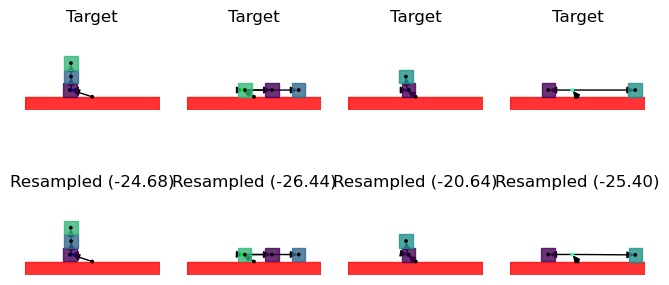

In [170]:
# Make sure we can directly encode trees for supervision correctly.
plt.figure(dpi=100).set_size_inches(8, 4)
n_ex = 4
for k in range(n_ex):
    plt.subplot(2, n_ex, k + 1)
    draw_boxes(full_trees_for_training[k], fig=plt.gcf(), ax=plt.gca(), block=False)
    plt.title("Target")
    plt.subplot(2, n_ex, k + 1 + n_ex)
    x_enc = encoder.get_grammar_parameters_from_actual_tree(meta_tree, full_trees_for_training[k])
    sampled_tree, ll, _ = encoder.sample_tree_from_grammar_vector(meta_tree, x_enc)
    draw_boxes(sampled_tree, fig=plt.gcf(), ax=plt.gca(), block=False)
    plt.title("Resampled (%.2f)" % ll)

Encoded x: tensor([-1.8093e-01, -3.0875e-02, -1.5902e-01, -1.6515e-01, -7.0461e-02,
         8.6245e-02,  4.0211e-01, -6.0595e-02,  2.9363e-01, -8.0045e-02,
         2.2759e-01, -6.5711e-02,  7.6840e-02, -1.5109e-01, -2.7008e-02,
         8.1420e-02,  1.9029e-01, -1.3566e-01, -8.5634e-02,  1.4401e-01,
        -8.8391e-02, -1.0768e-01, -2.8297e-01, -2.2890e-01, -7.9966e-02,
        -1.2700e-01, -1.2658e-01, -8.3872e-02, -6.8592e-02,  1.0897e-01,
        -2.5529e-01, -1.2619e-02,  3.3216e-02, -2.6521e-02,  8.6168e-03,
         7.7515e-02,  1.1481e-01, -2.7561e-01, -1.5411e-01, -5.8329e-02,
         2.2498e-01, -1.0905e-01, -2.3788e-01,  2.4589e-01, -1.5107e-01,
        -1.5093e-01,  1.3989e-01, -1.9028e-02,  2.4074e-01, -2.6357e-02,
         5.7386e-02, -1.7794e-01,  2.4819e-01, -1.1951e-05, -3.5439e-02,
        -1.8213e-01,  3.6750e-01, -2.1908e-02, -3.1594e-02,  3.6176e-02,
         4.0367e-02,  7.9004e-02,  2.1528e-01, -2.4160e-02, -4.0657e-01,
         3.7882e-02,  4.8723e-02, -7.066

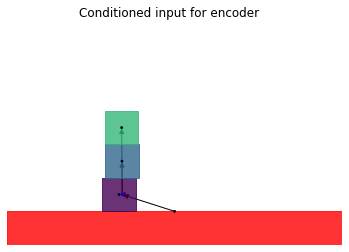

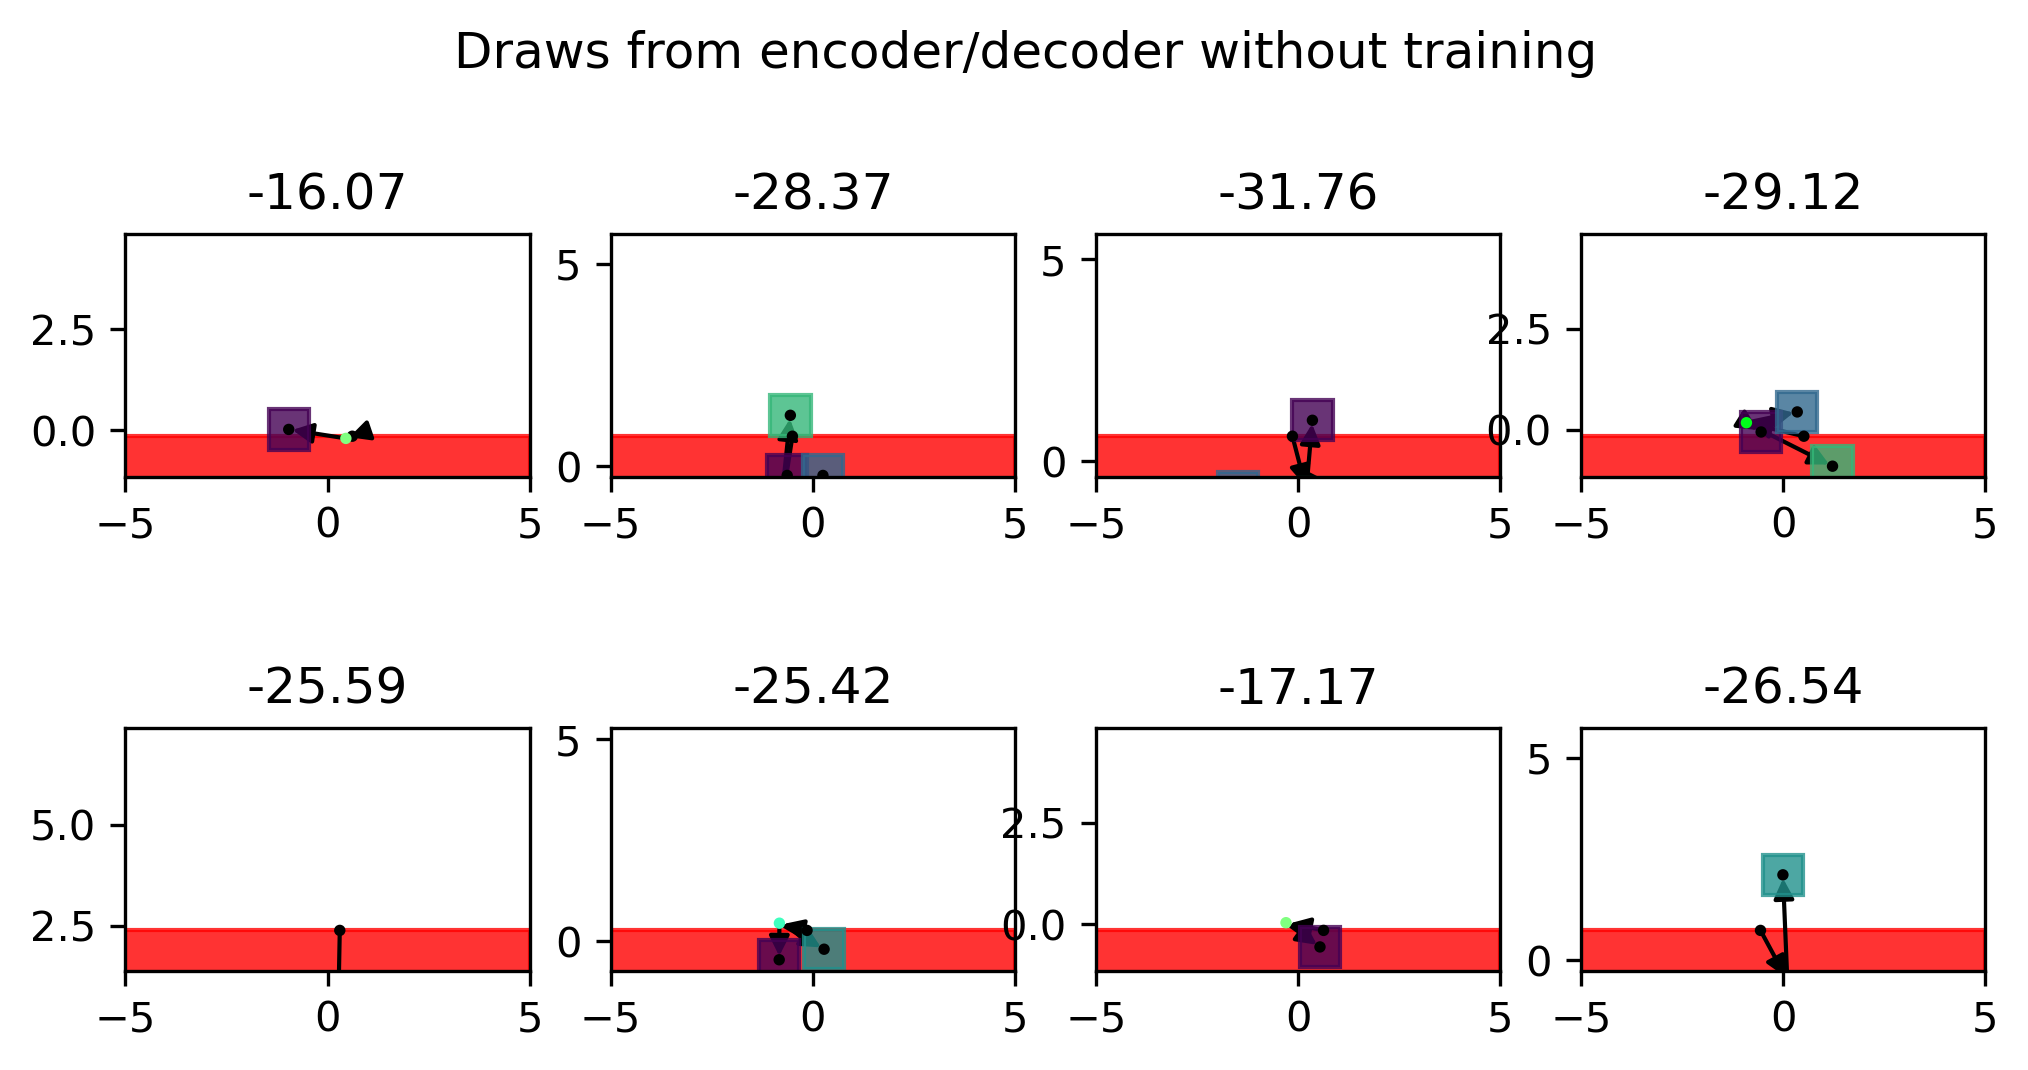

In [171]:
plt.figure()
plt.suptitle("Conditioned input for encoder")
draw_boxes(full_trees_for_training[0], fig=plt.gcf(), ax=plt.gca(), block=False)
x = encoder(observed_nodes_for_training[0])
print("Encoded x:", x)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
plt.suptitle("Draws from encoder/decoder without training")
N_width = 4
N_height = 2
torch.random.manual_seed(41)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        sampled_tree, ll, _ = encoder.sample_tree_from_grammar_vector(meta_tree, x)
        draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
        plt.title("%0.02f" % ll)
        ax.axis("on")
plt.show()

# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, we can match it into the meta tree, figure out the equivalent full-meta-tree-grammar parameters, and try to get the encoder to spit them out with direct supervised training. This is a sanity check, in some sense -- if this doesn't work, we can conclude the encoder doesn't have the representational power to make the full VAE work.



In [180]:
# Training
N_EPOCHS = 500
N_ITERS_PER_EPOCH = 100

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        full_tree = full_trees_for_training[iter_k]
        x_target = encoder.get_grammar_parameters_from_actual_tree(meta_tree, full_tree)
        # Penalize distance for non-nan terms
        target_mask = torch.isfinite(x_target)
        err = (x - x_target)[target_mask]
        total_objective += err.square().mean()
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f"
              % (epoch, mean_objective))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        optimizer.step()

0:Mean objective 32.95
1:Mean objective 25.87
2:Mean objective 20.38
3:Mean objective 17.29
4:Mean objective 15.44
5:Mean objective 14.31
6:Mean objective 13.60
7:Mean objective 12.95
8:Mean objective 12.24
9:Mean objective 11.55
10:Mean objective 10.83
11:Mean objective 10.16
12:Mean objective 9.69
13:Mean objective 9.13
14:Mean objective 8.74
15:Mean objective 8.27
16:Mean objective 7.83
17:Mean objective 7.45
18:Mean objective 7.04
19:Mean objective 6.72
20:Mean objective 6.38
21:Mean objective 6.04
22:Mean objective 5.74
23:Mean objective 5.41
24:Mean objective 5.06
25:Mean objective 4.82
26:Mean objective 4.46
27:Mean objective 4.19
28:Mean objective 3.93
29:Mean objective 3.66
30:Mean objective 3.40
31:Mean objective 3.18
32:Mean objective 2.95
33:Mean objective 2.75
34:Mean objective 2.55
35:Mean objective 2.39
36:Mean objective 2.22
37:Mean objective 2.05
38:Mean objective 1.90
39:Mean objective 1.75
40:Mean objective 1.62
41:Mean objective 1.50
42:Mean objective 1.38
43:Mean o

KeyboardInterrupt: 

Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

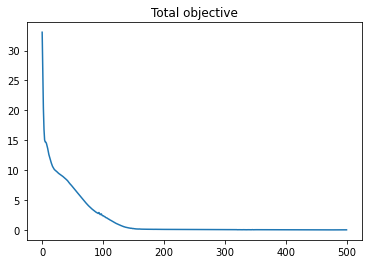

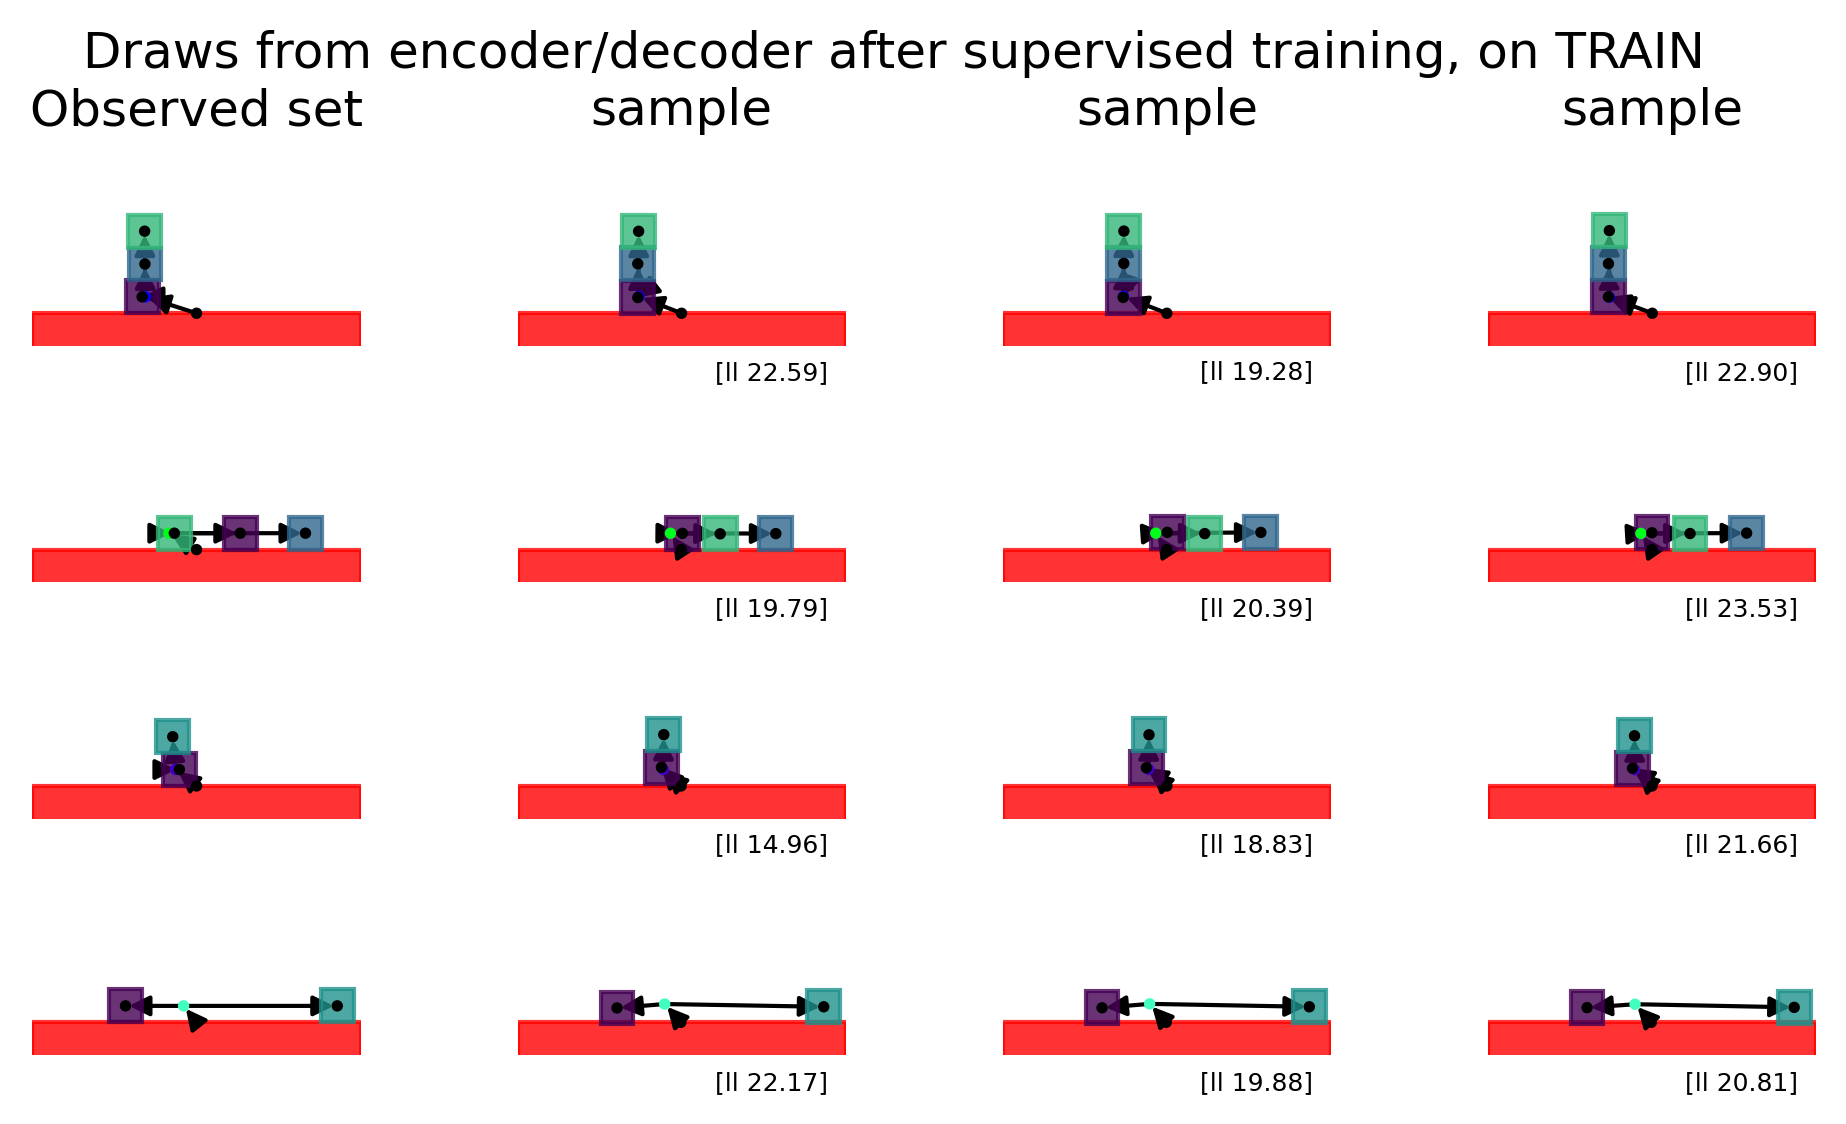

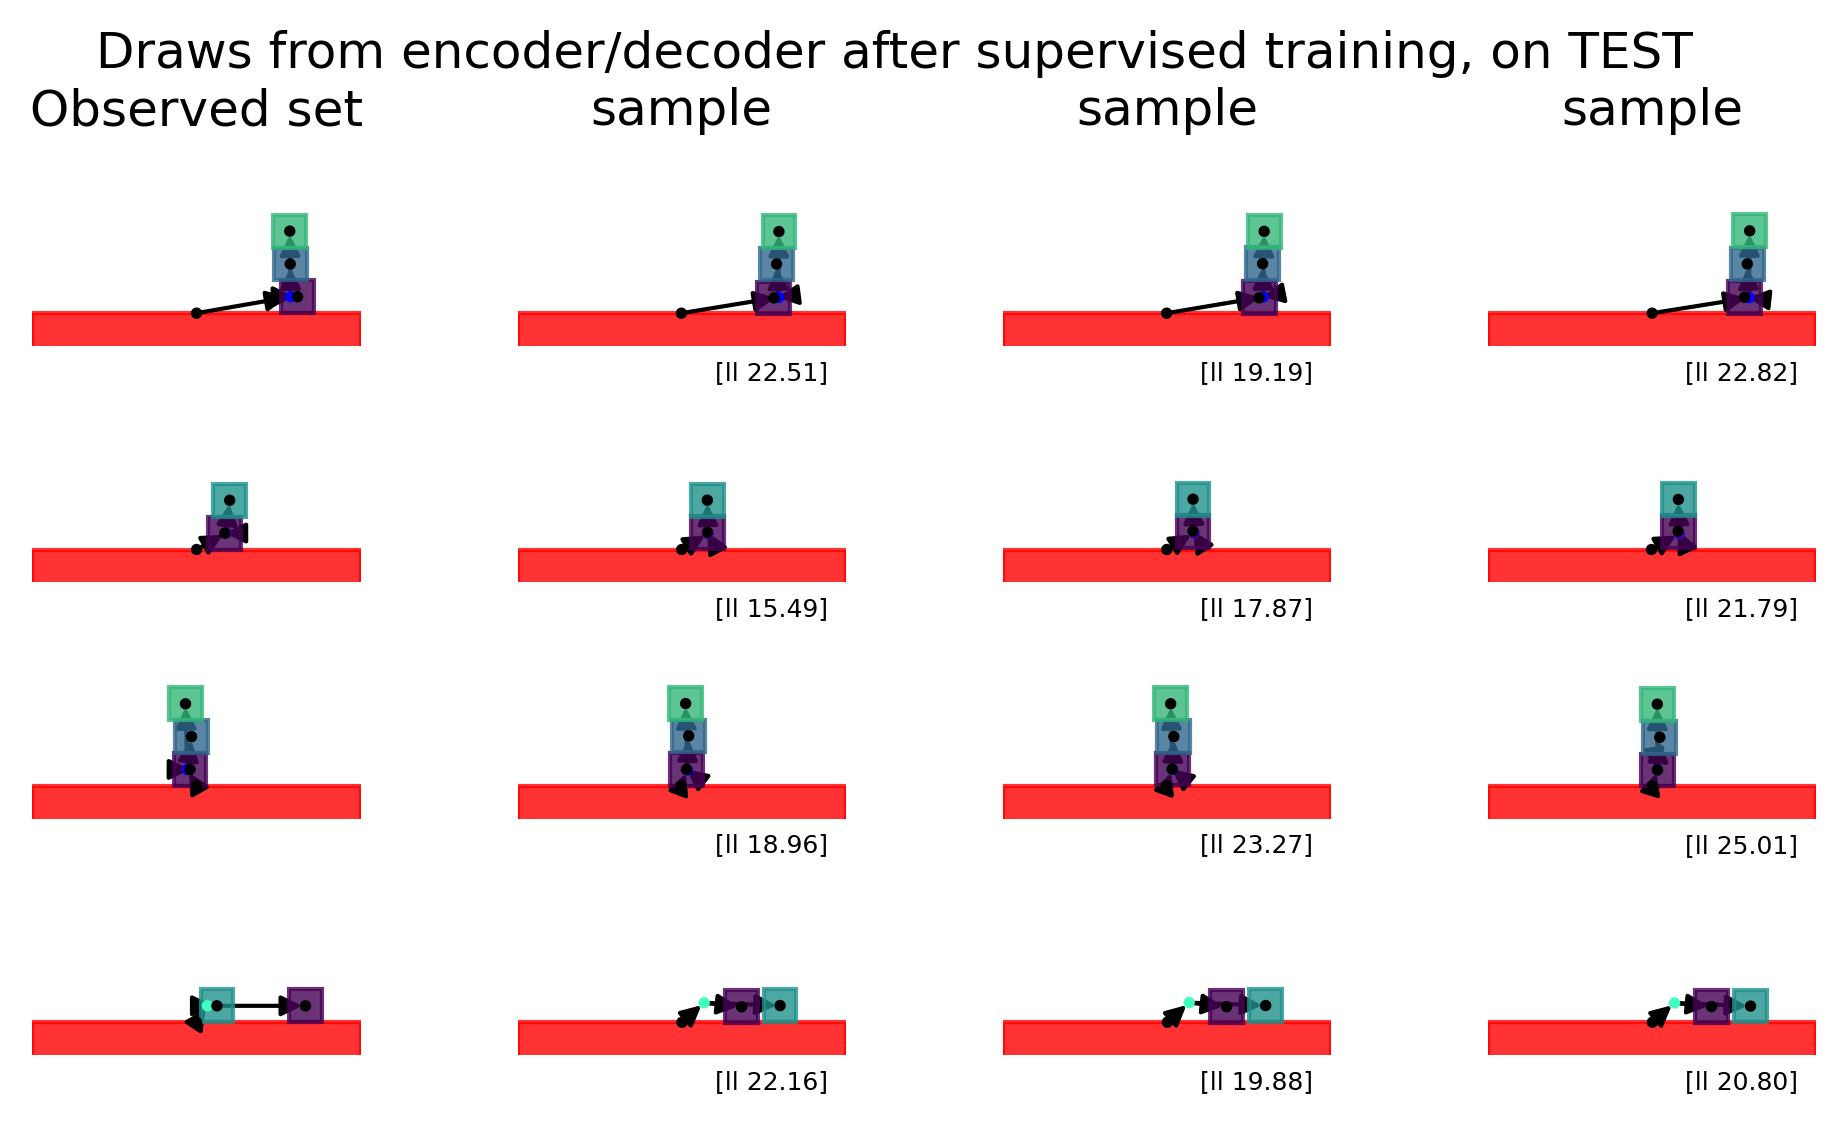

In [165]:
plt.plot(total_objective_history)
plt.title("Total objective")

def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(meta_tree, x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*)\Big] + log p(\theta)$. 

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [181]:
# Training
N_EPOCHS = 300
N_ITERS_PER_EPOCH = 10
N_SAMPLES_PER_ENCODING = 5
MIN_LL_SATURATION = -10000

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
mean_sampled_f_history = []
mean_sampled_score_history = []
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        x_prior_ll = dist.Normal(0., 1).log_prob(x).sum()
        total_objective += x_prior_ll / N_ITERS_PER_EPOCH
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, ll_parts = encoder.sample_tree_from_grammar_vector(meta_tree, x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            discrete_part_ll, _, _ = ll_parts
            # The discrete ll part is not reparameterized, so use REINFORCE.
            # The continuous part is reparameterized, so don't include it in the REINFORCE part.
            # (It'll come for free in the +total_f part.)
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1))
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            total_sampled_score += est_ll
            
            total_f = est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * discrete_part_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)
    
    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective))
    
    if torch.isfinite(mean_objective):
        (-mean_objective).backward()
        optimizer.step()

0: Mean sampled loss -20.58, f -20.58, Mean objective -40.15
1: Mean sampled loss -96.14, f -96.14, Mean objective -115.01
2: Mean sampled loss -82.59, f -82.59, Mean objective -99.87
3: Mean sampled loss -13.22, f -13.22, Mean objective -31.02
4: Mean sampled loss -43.71, f -43.71, Mean objective -62.64
5: Mean sampled loss -28.08, f -28.08, Mean objective -45.92
6: Mean sampled loss -55.25, f -55.25, Mean objective -73.54
7: Mean sampled loss -12.94, f -12.94, Mean objective -30.50
8: Mean sampled loss -9.22, f -9.22, Mean objective -27.66
9: Mean sampled loss -27.95, f -27.95, Mean objective -44.99
10: Mean sampled loss -34.98, f -34.98, Mean objective -50.98
11: Mean sampled loss -5.18, f -5.18, Mean objective -21.58
12: Mean sampled loss -11.18, f -11.18, Mean objective -27.92
13: Mean sampled loss -35.76, f -35.76, Mean objective -52.04
14: Mean sampled loss -18.05, f -18.05, Mean objective -33.85
15: Mean sampled loss -13.39, f -13.39, Mean objective -28.62
16: Mean sampled loss

136: Mean sampled loss 2.16, f 2.16, Mean objective -4.34
137: Mean sampled loss 3.88, f 3.88, Mean objective -3.14
138: Mean sampled loss 1.78, f 1.78, Mean objective -5.82
139: Mean sampled loss -0.75, f -0.75, Mean objective -9.34
140: Mean sampled loss -8.15, f -8.15, Mean objective -15.79
141: Mean sampled loss -5.88, f -5.88, Mean objective -13.95
142: Mean sampled loss -4.85, f -4.85, Mean objective -12.14
143: Mean sampled loss -1.37, f -1.37, Mean objective -9.09
144: Mean sampled loss 4.29, f 4.29, Mean objective -4.00
145: Mean sampled loss -10.56, f -10.56, Mean objective -18.69
146: Mean sampled loss -2.65, f -2.65, Mean objective -10.36
147: Mean sampled loss -28.90, f -28.90, Mean objective -36.95
148: Mean sampled loss -0.15, f -0.15, Mean objective -7.54
149: Mean sampled loss 0.14, f 0.14, Mean objective -7.48
150: Mean sampled loss -9.39, f -9.39, Mean objective -16.58
151: Mean sampled loss 0.72, f 0.72, Mean objective -6.89
152: Mean sampled loss -23.00, f -23.00, 

273: Mean sampled loss 1.38, f 1.38, Mean objective -5.63
274: Mean sampled loss -2.16, f -2.16, Mean objective -8.49
275: Mean sampled loss 0.37, f 0.37, Mean objective -7.20
276: Mean sampled loss 3.36, f 3.36, Mean objective -3.28
277: Mean sampled loss 0.61, f 0.61, Mean objective -6.75
278: Mean sampled loss -1.80, f -1.80, Mean objective -9.23
279: Mean sampled loss 2.49, f 2.49, Mean objective -3.69
280: Mean sampled loss 0.71, f 0.71, Mean objective -6.53
281: Mean sampled loss 1.62, f 1.62, Mean objective -5.91
282: Mean sampled loss 0.91, f 0.91, Mean objective -6.62
283: Mean sampled loss 0.99, f 0.99, Mean objective -6.58
284: Mean sampled loss 0.80, f 0.80, Mean objective -6.30
285: Mean sampled loss 0.24, f 0.24, Mean objective -7.30
286: Mean sampled loss 2.04, f 2.04, Mean objective -4.41
287: Mean sampled loss 0.27, f 0.27, Mean objective -6.69
288: Mean sampled loss 0.61, f 0.61, Mean objective -6.66
289: Mean sampled loss -10.56, f -10.56, Mean objective -17.66
290: 

Text(0.5, 1.0, 'Total objective')

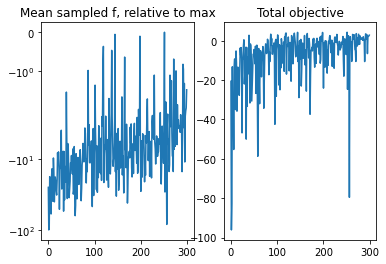

In [195]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

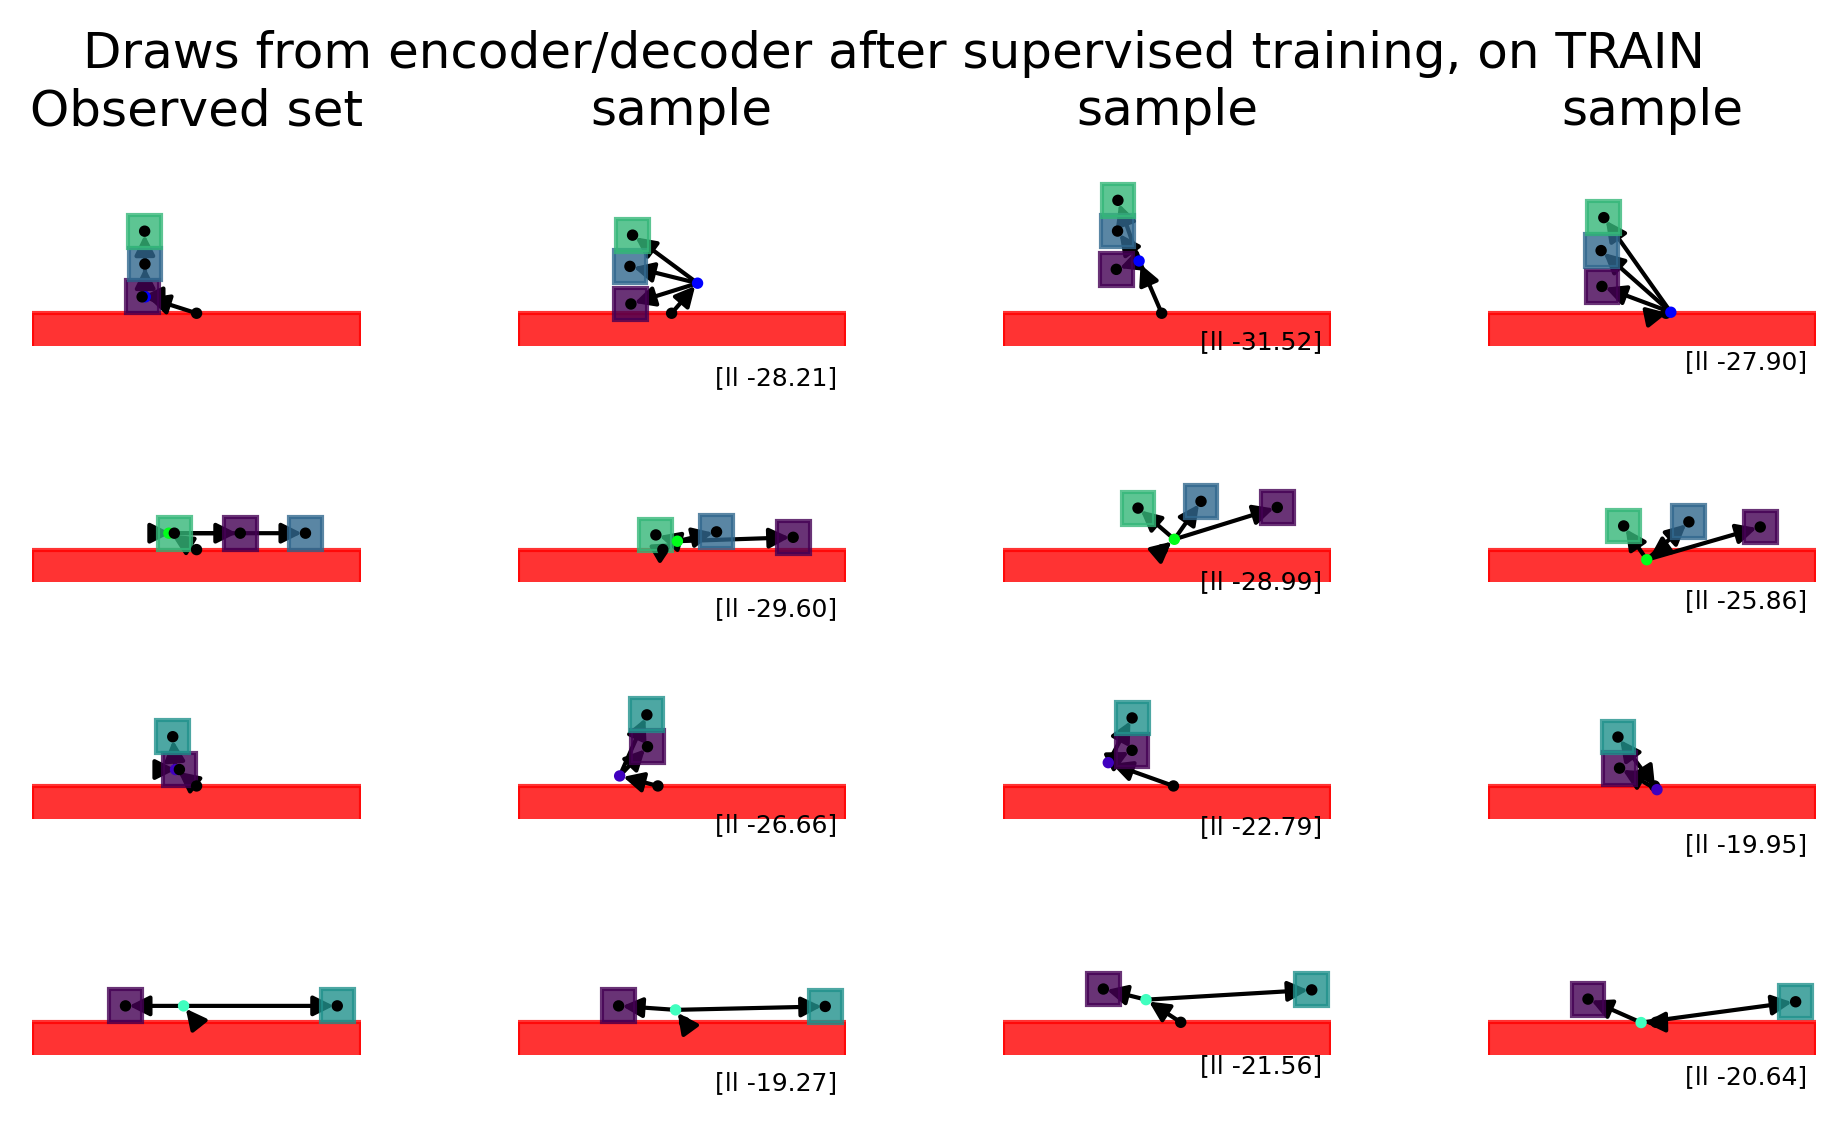

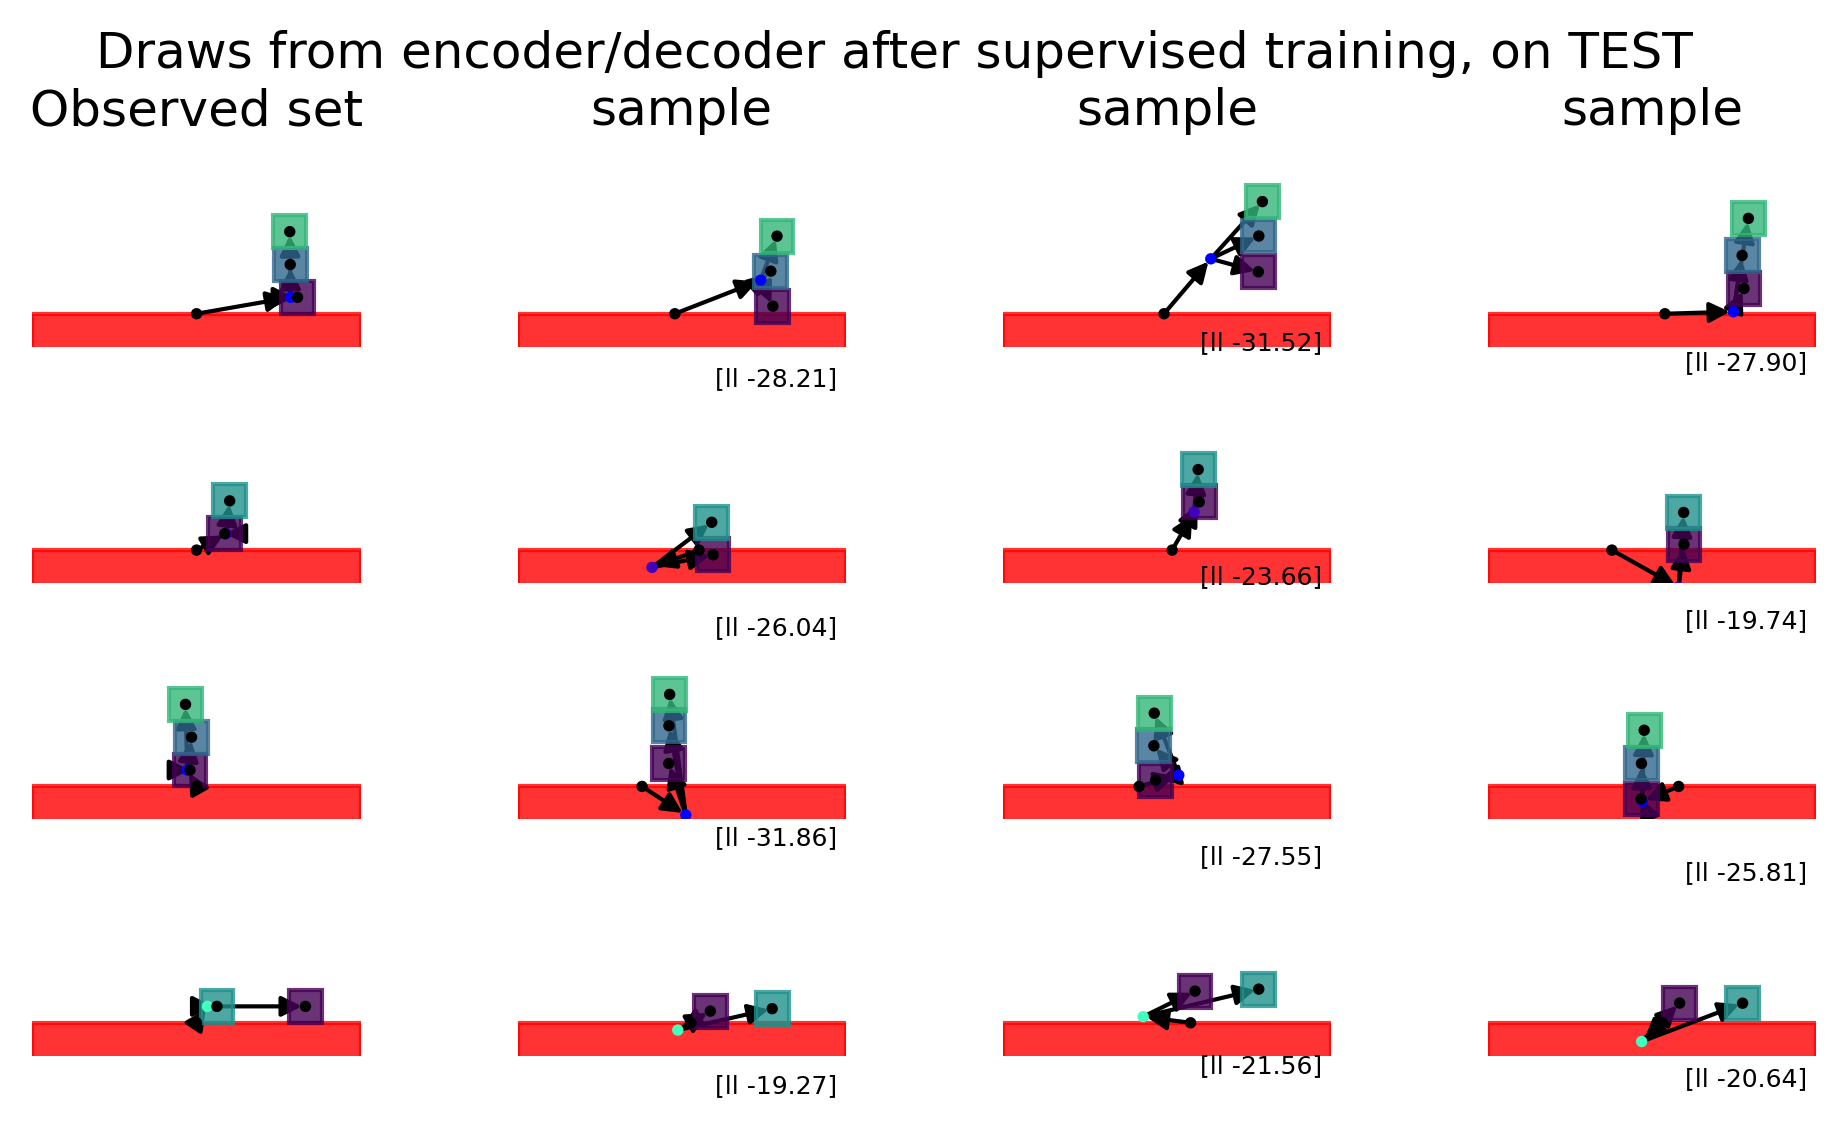

In [196]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(meta_tree, x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")


## Approach that leverages super-scene-tree?
Mixed-integer something? With a highly constrained spatial grammar, that might be possible...

Given the super-tree for the grammar $V_{g}, E_{g}$ and an observed set of nodes $V_{obs}$, create an edge between every terminal node and every matching-kind member of the observed set. The resulting graph ("super-observed-graph"?)  (not a tree, because observed nodes might be connected to multiple terminal nodes from different branches) contains every valid parse tree for the scene as a subgraph. So searching for parses could be framed as searching over valid subtrees. (I think this is related to a traveling salesman sort of problem, but we need to simultaneously search for node parameters

Or could view it like a tree form of a parse table, like from the inside-out algorithm. Each node's value in this graph 

For each node in the super-tree, depending on the node type (AND vs OR vs SET), different subsets of children are allowed to be active, with different subsets being active being given different scores based on the node rules. The connectivity between terminal nodes + observed nodes must be one-to-one, with edge weights providing scoring.

This could directly be written as a MIP. It's MINLP for the general version, but the following structure is convex:
- AND nodes are direct implications from binary variable to binary variable.
- OR and SET nodes are direct maps from the set of active binaries to the cost induced. (But may be easier to write with one binary per valid set of active children for the SET case, rather than one binary per child.) 
- The joint probability of a parent and child needs to be convex in log prob space. Relative normal pose distributions might be able to fit this, as long as the mean/variance of the normal isn't itself parameterized?
- Any constraints need to be convex (hopefully linear) in the parameters.
But MIP solvers (even MINLP) are going to generally try to give me optimal parameter sets -- not samples from the posterior of parameter sets. Maybe I could utilize some internals from BnB to find the set of solutions that have probability over some threshold, and then do enumeration over that (hopefully vastly-reduced) set?

## Bottom-up parsing with neural recognizers:
Bottom-up parsing: create a proposal function $q(t | o)$ that takes a set of observed nodes and spits out a completed tree (with reported density). Starting from a tree with just the observed nodes (with their attributes set):

Algo 1: This traverses node-by-node, deciding whether to add each candidate node and which unclaimed children to claim in a post-ordered DFS.

1) Generate the meta-tree and a deterministic postorder (bottom-up) traversal iteration order.

2) Select node to add as the next node in the iteration order, and build its full set of potential children. If the set is empty, loop to (2).

3) Assign each potential child set a weight and choose from among them as a Categorical draw; then predict the new node's local parameters conditioned on the resulting child set. Finally, 

4) Add the new node + its connections to the children to the tree. Loop to (2) if the tree has orphans left.

5) The resulting density $q(t | o)$ is the product of densities for each selection and random draw. 

Algo 2: Could operate over sets of nodes rather than sequentially passing through them: where algo 1 is like an RNN, this is like a transformer. The sets of nodes under consideration to be claimed are chosen outside-in in the tree through an iterative procedure: first all "observable" nodes are marked as considered. Then, each subsequent set is the set of nodes in the tree whose children are all marked as considered; after an evaluation pass, all nodes in that set are marked as considered. An "evaluation pass" needs to result in the introduction of new nodes with associated child sets.

In both cases, neural models are trained directly supervised on data from trees drawn from the prior.


You can imagine that, starting from a set of observed nodes, there's a tree of decisions you can make, with leaves being resulting parsed trees. The proposal density of a tree is the product of probabilities of each branching decision made; I'm pretty sure this proposal density is properly normalized as long as each component proposal density is normalized. (You *can't* compare proposal densities between resulting trees of different structure, though, since the set of variables changes! Imagine one of those branches has a continuous variable with a tightly peaked Gaussian, and the other branch doesn't have that variable -- the Gaussian might inflate or deflate the proposal density at the proposal compared to the other branch. But the integration over all proposal densities is still reasonable, and you can compare e.g. the proposal density and the joint $p(t, o)$ at a point since the trees have the same structure.)

**Problem: it's not a legitimate proposal density if the procedure can spit out the same tree through two different decision paths. I *think* this method has a deterministic route to each parse tree, as each node is only considered for membership once, and always in the same order. But two more problems emerge: the major one is that this procedure is likely to get confused and produce infeasible trees or not explain every node, since any mistake made in the selection process is un-fixable. The minor one is that if there are multiple "equivalent" but technically distinct trees that explain the data (e.g. using the 1st vs 2nd in a geometric set of stacks to explain a stack of objects), those are considered different as far as density goes.** The approach [here](http://proceedings.mlr.press/v37/salimans15.pdf) to adding auxiliary variables appears to be training an additional "auxiliary inference distribution" $r(y|x, z)$ - the variational posterior draws from $q(y, z | x)$ (here y is the "path" taken to get to the sampled tree and x is the sampled tree itself for observed z), and $r(y | x, z)$ approximates $q(x | z, x)$ (which is hard to calculate). It appears to add an additional KL divergence term to the ELBO. I believe $r$ only needs to be able to provide a density estimate (to appear in the ELBO), but in the paper their $r$'s are sample-able. (e.g. a neural net that spits out a mean + variance for the appropriate variables).

If I think of the parsing machinery as doing MCTS, can I put any bounds on the total prob of the unexplored branches, to at last try to quantify this problem?

TODOs here:
1) Prototype this process, subbing out the neural proposal densities for uninformed proposal densities over the support of the relevant variables.
2) Prototype the neural proposal densities -- what architecture can achieve this? Big difficulty is varying input size without a reasonable upper bound -- GNN's might be the route, and have been demonstrated to work in metasim.

In [ ]:
def sample_tree_proposal(observed_tree, root_node_type):
    '''
    Assumptions:
    - observed_tree contains only fully instantiated
    nodes. No forward sampling is done further down
    that these nodes; these nodes will be the set of
    leaves of the proposed trees.
    '''
    for node in observed_tree:
        assert node.instantiated
    proposed_tree = deepcopy(observed_tree)
    # Build list of orphans.
    orphans = []
    for n in proposed_tree.nodes():
        if not isinstance(n, root_node_type):
            if proposed_tree.get_node_parent_or_none(n) is None:
                orphans.append(n)
    
    # We'll use the meta tree as the structure for
    # tracking what nodes are available to add at a given
    # moment.
    meta_tree = SceneTree.make_meta_scene_tree(root_node_type())
    ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
    
    for candidate_node in ordering:
        # Evaluate whether we can add this candidate node.
        if isinstance(candidate_node, TerminalNode):
            continue
        # Build candidate child set.
        candidate_child_types = [n.__class__ for n in meta_tree.successors(candidate_node)]
        candidate_children = []
        for child_candidate in orphans:
            if child_candidate.__class__ in candidate_child_types:
                candidate_children.append(child_candidate)
        N_candidates = len(candidate_children)
        print("Child candidate size: ", N_candidates)
        if N_candidates == 0:
            continue
        
        # Select a set of children.
        # Most naive but complete: choose a combination of them.
        probs = torch.ones(2**N_candidates)
        choice = pyro.sample("%s_child_choice" % candidate_node.name,
                             dist.Categorical(probs)).item()
        accepted_children = []
        # How do I validate that this is feasible?
    
    # How do I deal with trees that generated but aren't feasible / don't
    # explain all nodes?
        
        
    proposal_density = np.nan
    return proposed_tree, proposal_density
print(sample_tree_proposal(observed_trees[2], Ground))

In [ ]:
# Try to implement a "node recognizer", just to get some implementation details knocked out.
class NodeRecognizer(torch.nn.Module):
    ''' Specialized recognizer that operates from the perspective of a candidate
    nonterminal node in the tree. Given the candidate node's current distribution
    over its parameters and a set of instantiated child nodes of appropriate types,
    produces a Bernoulli prob per child indicating inclusion of that child in the
    child set of this node, and 
    '''
    def 

In [ ]:
# Try to implement a graph inference network:
# given an observed node set and a grammar, take the
# meta tree + add grounding connections between every observed
# node and all places it could fit in the tree.
# The node attributes in the GCN are:
#   - Mean + variance estimate for node attributes
# The edge attributes are:
#   - Probability of this edge being active (to be
#     normalized across all incoming edges for the node)

import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# Build torch_geometric-compatible Data unit from
# observed scenes
def convert_observed_tree_and_meta_tree_to_tg_data(observed_tree, meta_tree):
    nodes_in_order = list(meta_tree.nodes) + list(observed_tree.nodes)
    N_nodes = len(nodes_in_order)
    
    # Build attributes -- just poses, in this case.
    x = [n.xy for n in observed_tree.nodes]
    # Build bidirectional edges from adjacency matrix.
    # (Uses ordering of nodes from observed_tree.nodes)
    C = nx.adjacency_matrix(observed_tree)
    
    
    edge_index = []
        
    return Data()

x (Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)

edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)

edge_attr (Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)

y (Tensor, optional) – Graph or node targets with arbitrary shape. (default: None)

pos (Tensor, optional) – Node position matrix with shape [num_nodes, num_dimensions]. (default: None)

normal (Tensor, optional) – Normal vector matrix with shape [num_nodes, num_dimensions]. (default: None)

face (LongTensor, optional) – Face adjacency matrix with shape [3, num_faces]. (default: None)

data_list = [Data(...), ..., Data(...)]
loader = DataLoader(data_list, batch_size=32)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
